### Import Packages

SKLearn library forces depreciation warnings which have no effect on the reliability of the project, so these will be silenced here

In [1]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [2]:
import numpy as np
import pandas as pd

# machine learning specific functions
from pandas.plotting import scatter_matrix
from matplotlib import pyplot
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

%store -r df

### Perform Model

#### Create Validation Dataset

In [3]:
# get classifier values (online, offline)
y = df['status'].values

# get station name values
X1 = df['station_name']

# get all values that are after the status (timing information and prediction values)
status_index = df.columns.get_loc('status')
X2 = df.iloc[:, status_index + 1:]

# combine X1 and X2
X = pd.concat([X1, X2], axis=1).values

X_train, X_validation, y_train, y_validation = train_test_split(X, y, test_size=0.20, random_state=7)

X_train = X_train.astype('float')
X_validation = X_validation.astype('float')
y_train = y_train
y_validation = y_validation

#### Assign Models that should be tested

In [4]:
models = []
models.append(('LR', LogisticRegression(solver='liblinear', multi_class='ovr')))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))

#### Evaluate Each Model

In [5]:
results = []
names = []
for name, model in models:
	kfold = StratifiedKFold(n_splits=10, random_state=1, shuffle=True)
	cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring='accuracy')
	results.append(cv_results)
	names.append(name)
	print('%s: %f (%f)' % (name, cv_results.mean(), cv_results.std()))

LR: 0.946143 (0.003017)
LDA: 0.925866 (0.002982)
KNN: 0.945727 (0.002846)
CART: 0.923229 (0.004027)
NB: 0.713275 (0.040604)


#### Compare Algorithms

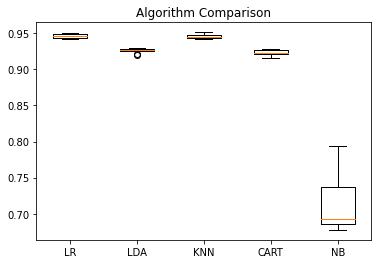

In [6]:
pyplot.boxplot(results, labels=names)
pyplot.title('Algorithm Comparison')
pyplot.show()

#### Choose Model with highest Precision

In [7]:
max_prec = 0

for index in range(0, len(models)):
    prec = results[index].mean()

    if prec > max_prec:
        max_prec = prec
        model = models[index]

print('Algorithm ' + model[0] + ' scored highest precision')

# model consists of tuple with name
model = model[1]

Algorithm LR scored highest precision


#### Fit selected Model

In [8]:
model.fit(X_train, y_train)
predictions = model.predict(X_validation)

#### Evaluate Predictions 

In [10]:
print('Accuracy Score:')
print(accuracy_score(y_validation, predictions))
print(' ')
print('Confusion Matrix:')
print(confusion_matrix(y_validation, predictions))
print(' ')
print('Classification Report:')
print(classification_report(y_validation, predictions))
print(' ')

Accuracy Score:
0.9501308174106081
 
Confusion Matrix:
[[  203   534]
 [   95 11781]]
 
Classification Report:
              precision    recall  f1-score   support

     offline       0.68      0.28      0.39       737
      online       0.96      0.99      0.97     11876

    accuracy                           0.95     12613
   macro avg       0.82      0.63      0.68     12613
weighted avg       0.94      0.95      0.94     12613

 
